In [1]:
import os
import re
import plotly.express as px
import numpy as np
from collections import Counter
import plotly.graph_objects as go

def extract_info(filename):
    pattern = r'sense_polar_([\w-]+)_dim(\d+)_(\w+)_(\w+)_layer(\d+)_(train|test).txt'
    match = re.match(pattern, filename)
    if match:
        model_name, polar_dimension, polarity_method, dataset_method, layer, train_or_test = match.groups()
        return {
            'model_name': model_name,
            'polar_dimension': int(polar_dimension),
            'polarity_method': polarity_method,
            'dataset_method': dataset_method,
            'layer': int(layer),
            'train_or_test': train_or_test
        }
    return None

def parse_train_loss_values(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    loss_values = []
    for line in lines:
        if 'Train Loss:' in line:
            loss = float(line.split('Train Loss:')[1].split(',')[0])
            loss_values.append(loss)
    return loss_values

def parse_valid_loss_values(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    loss_values = []
    for line in lines:
        if 'Valid Loss:' in line:
            loss = float(line.split('Valid Loss:')[1].split(',')[0])
            loss_values.append(loss)
    return loss_values
    
def parse_test_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    accuracy = float(lines[0].split(',')[1].strip().split(':')[1])
    loss = float(re.search(r'Test Loss: ([\d.]+)', lines[0]).group(1))
    
    report_start = lines.index('Classification Report:\n') + 1
    report_lines = lines[report_start:]
    class_names = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    support_list = []
    for line in report_lines[2:-4]: 
        values = line.split()
        class_name = values[0]
        precision, recall, f1_score, support = map(float, values[1:])
        class_names.append(class_name)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        support_list.append(int(support))
    return accuracy, loss, class_names, precision_list, recall_list, f1_score_list, support_list

def plot_train_loss(train_data):
    train_loss_fig = px.line()
    for train_file, data in train_data.items():
        info = data['info']
        title = f"Train Loss Curve: Model={info['model_name']}, Dim={info['polar_dimension']}, Polarity={info['polarity_method']}, Dataset={info['dataset_method']}, Layer={info['layer']}"
        train_loss_fig.add_scatter(x=np.arange(1, len(data['train_loss_values']) + 1 - 50), y=data['train_loss_values'], mode='lines', name=title)
    train_loss_fig.update_layout(title='Train Loss Curves', xaxis_title='Epoch', yaxis_title='Loss')
    train_loss_fig.show()

def plot_valid_loss(train_data):
    valid_loss_fig = px.line()
    for train_file, data in train_data.items():
        info = data['info']
        title = f"Valid Loss Curve: Model={info['model_name']}, Dim={info['polar_dimension']}, Polarity={info['polarity_method']}, Dataset={info['dataset_method']}, Layer={info['layer']}"
        valid_loss_fig.add_scatter(x=np.arange(1, len(data['valid_loss_values']) + 1 - 50), y=data['valid_loss_values'], mode='lines', name=title)
    valid_loss_fig.update_layout(title='Train Loss Curves', xaxis_title='Epoch', yaxis_title='Loss')
    valid_loss_fig.show()
    
def plot_test_accuracy(test_data):
    test_accuracy_fig = px.scatter()
    for test_file, data in test_data.items():
        info = data['info']
        accuracy = data['accuracy']
        model_info = f"Model={info['model_name']}, Dim={info['polar_dimension']}, Polarity={info['polarity_method']}, Dataset={info['dataset_method']}, Layer={info['layer']}"
        scatter_trace = px.scatter(x=[model_info], y=[accuracy])
        scatter_trace.data[0].name = "Test Accuracy"
        test_accuracy_fig.add_trace(scatter_trace.data[0])
    test_accuracy_fig.update_layout(title='Test Accuracy by Model', xaxis_title='Model Name', yaxis_title='Test Accuracy')
    test_accuracy_fig.show()

def plot_test_loss(test_data):
    test_loss_fig = px.scatter()
    for test_file, data in test_data.items():
        info = data['info']
        loss = data['loss']
        model_info = f"Model={info['model_name']}, Dim={info['polar_dimension']}, Polarity={info['polarity_method']}, Dataset={info['dataset_method']}, Layer={info['layer']}"
        scatter_trace = px.scatter(x=[model_info], y=[loss])
        scatter_trace.data[0].name = "Test Loss"
        test_loss_fig.add_trace(scatter_trace.data[0])
    test_loss_fig.update_layout(title='Test Loss by Model', xaxis_title='Model Name', yaxis_title='Test Loss')
    test_loss_fig.show()

def plot_accuracy_loss_scatter(test_data):
    scatter_data = {
        'Accuracy': [data['accuracy'] for data in test_data.values()],
        'Loss': [data['loss'] for data in test_data.values()],
        'Model Info': [f"Model={data['info']['model_name']}, Dim={data['info']['polar_dimension']}, Polarity={data['info']['polarity_method']}, Dataset={data['info']['dataset_method']}, Layer={data['info']['layer']}" for data in test_data.values()]
    }
    scatter_fig = px.scatter(scatter_data, x='Accuracy', y='Loss', hover_name='Model Info', title='Test Loss vs Test Accuracy')
    scatter_fig.show()

def find_best_model(test_data):
    best_accuracy = 0.0
    best_model = None
    for test_file, data in test_data.items():
        accuracy = data['accuracy']
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = test_file
    return best_model

def find_top_models_by_accuracy(test_data, top_n=5):
    model_settings = []
    for test_file, data in test_data.items():
        model_settings.append((
            data['info']['model_name'],
            data['info']['polar_dimension'],
            data['info']['polarity_method'],
            data['info']['dataset_method'],
            data['info']['layer']
        ))
    
    sorted_models_by_accuracy = sorted(model_settings, key=lambda x: max([d['accuracy'] for d in test_data.values() if d['info']['model_name'] == x[0] and
                                                                      d['info']['polar_dimension'] == x[1] and
                                                                      d['info']['polarity_method'] == x[2] and
                                                                      d['info']['dataset_method'] == x[3] and
                                                                      d['info']['layer'] == x[4]]), reverse=True)

    print(f"Top {top_n} Models Sorted by Maximum Accuracy:")
    for setting in sorted_models_by_accuracy[:top_n]:
        print("Settings:", setting)
        matching_data = [data for data in test_data.values() if data['info']['model_name'] == setting[0] and
                         data['info']['polar_dimension'] == setting[1] and
                         data['info']['polarity_method'] == setting[2] and
                         data['info']['dataset_method'] == setting[3] and
                         data['info']['layer'] == setting[4]]
        
        best_accuracy_data = max(matching_data, key=lambda x: x['accuracy'])
        print("Maximum Accuracy:", best_accuracy_data['accuracy'])
        print("Test Loss:", best_accuracy_data['loss'])
        print("Class Names:", best_accuracy_data['class_names'])
        print("Precision:", best_accuracy_data['precision'])
        print("Recall:", best_accuracy_data['recall'])
        print("F1 Score:", best_accuracy_data['f1_score'])
        print("Support:", best_accuracy_data['support'])
        print()

def find_top_models_by_loss(test_data, top_n=5):
    model_settings = []
    for test_file, data in test_data.items():
        model_settings.append((
            data['info']['model_name'],
            data['info']['polar_dimension'],
            data['info']['polarity_method'],
            data['info']['dataset_method'],
            data['info']['layer']
        ))
    
    sorted_models_by_loss = sorted(model_settings, key=lambda x: min([d['loss'] for d in test_data.values() if d['info']['model_name'] == x[0] and
                                                                      d['info']['polar_dimension'] == x[1] and
                                                                      d['info']['polarity_method'] == x[2] and
                                                                      d['info']['dataset_method'] == x[3] and
                                                                      d['info']['layer'] == x[4]]))

    print(f"Top {top_n} Models Sorted by Minimum Loss:")
    for setting in sorted_models_by_loss[:top_n]:
        print("Settings:", setting)
        matching_data = [data for data in test_data.values() if data['info']['model_name'] == setting[0] and
                         data['info']['polar_dimension'] == setting[1] and
                         data['info']['polarity_method'] == setting[2] and
                         data['info']['dataset_method'] == setting[3] and
                         data['info']['layer'] == setting[4]]
        
        best_loss_data = min(matching_data, key=lambda x: x['loss'])
        print("Minimum Loss:", best_loss_data['loss'])
        print("Accuracy:", best_loss_data['accuracy'])
        print("Class Names:", best_loss_data['class_names'])
        print("Precision:", best_loss_data['precision'])
        print("Recall:", best_loss_data['recall'])
        print("F1 Score:", best_loss_data['f1_score'])
        print("Support:", best_loss_data['support'])
        print()

def plot_metrics_for_model_layers(test_data, model_name, polar_dimension, polarity_method, dataset_method):
    matching_data = [data for data in test_data.values() if data['info']['model_name'] == model_name and
                     data['info']['polar_dimension'] == polar_dimension and
                     data['info']['polarity_method'] == polarity_method and
                     data['info']['dataset_method'] == dataset_method]
    
    if not matching_data:
        print(f"No data found for the specified model: {model_name}")
        return
    
    layers = [data['info']['layer'] for data in matching_data]
    accuracy_values = [data['accuracy'] for data in matching_data]
    loss_values = [data['loss'] for data in matching_data]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=layers, y=accuracy_values, mode='lines+markers', name='Accuracy'))
    fig.add_trace(go.Scatter(x=layers, y=loss_values, mode='lines+markers', name='Loss', line=dict(color='red')))
    fig.update_layout(
        xaxis_title='Layer',
        yaxis_title='Value',
        title=f'Performance Metrics for Model: {model_name} {polar_dimension} {polarity_method} {dataset_method}',
        legend=dict(x=0, y=1, traceorder='normal')
    )
    fig.show()



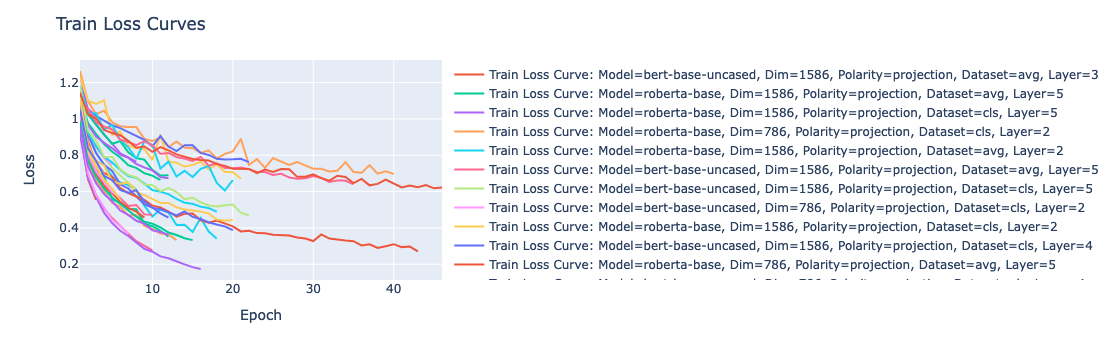

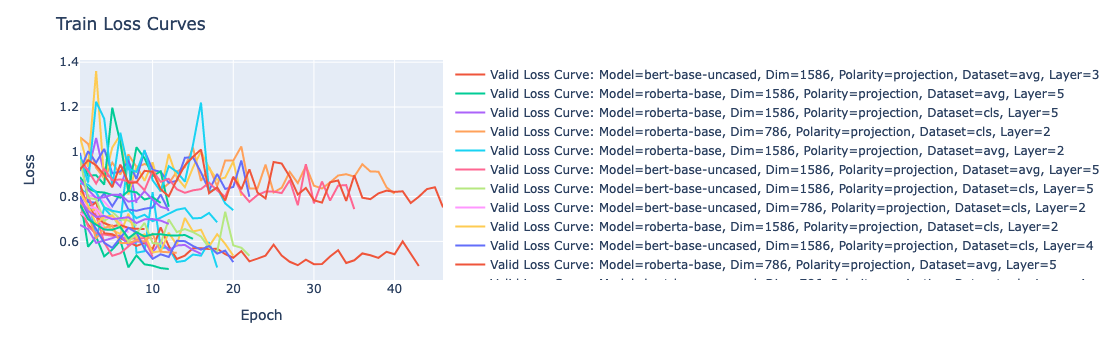

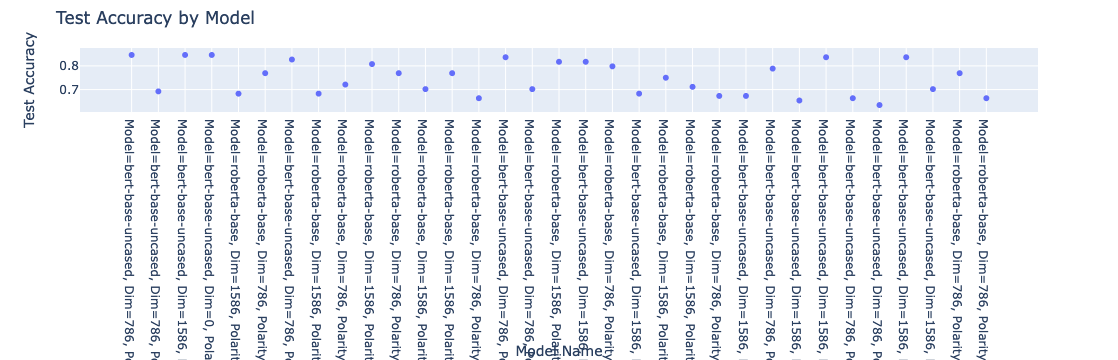

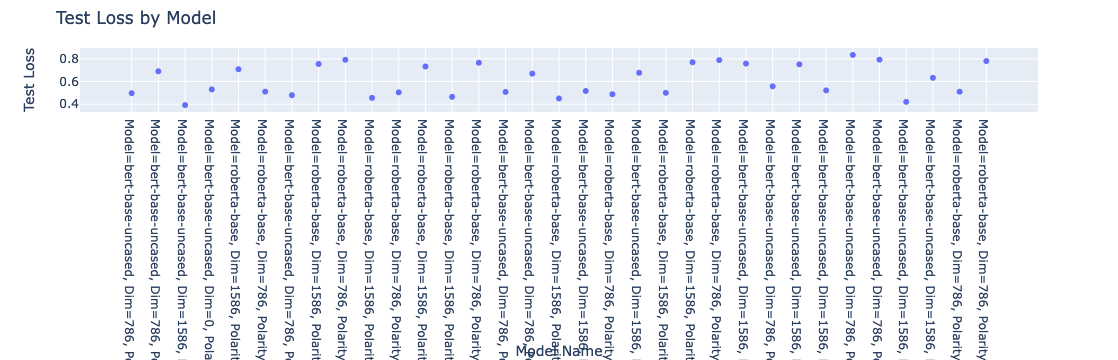

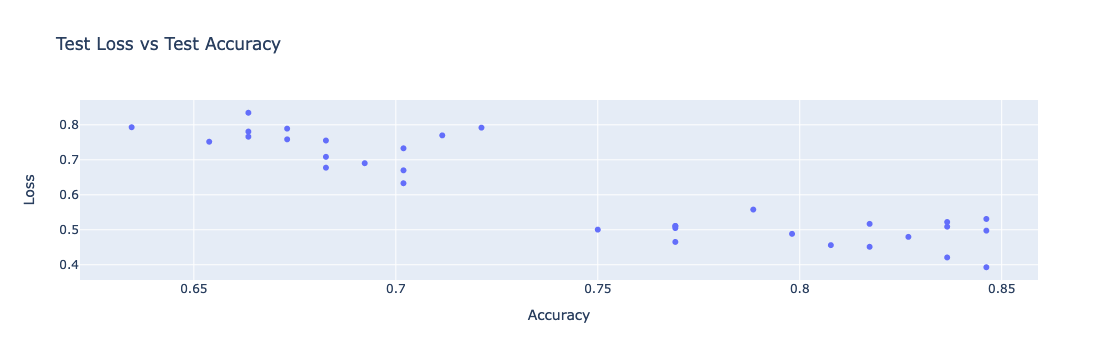

The best model is 'sense_polar_bert-base-uncased_dim786_projection_avg_layer5_test.txt' with an accuracy of 0.8462
Top 5 Models Sorted by Maximum Accuracy:
Settings: ('bert-base-uncased', 786, 'projection', 'avg', 5)
Maximum Accuracy: 0.8462
Test Loss: 0.4975
Class Names: ['0', '1', '2', '3']
Precision: [0.8889, 0.8571, 0.8571, 0.0]
Recall: [0.8421, 0.375, 0.9565, 0.0]
F1 Score: [0.8649, 0.5217, 0.9041, 0.0]
Support: [19, 16, 69, 0]

Settings: ('bert-base-uncased', 1586, 'projection', 'avg', 5)
Maximum Accuracy: 0.8462
Test Loss: 0.3929
Class Names: ['0', '1', '2', '3']
Precision: [0.9333, 0.875, 0.8375, 0.0]
Recall: [0.7368, 0.4375, 0.971, 0.0]
F1 Score: [0.8235, 0.5833, 0.8993, 0.0]
Support: [19, 16, 69, 0]

Settings: ('bert-base-uncased', 0, '0', '0', 0)
Maximum Accuracy: 0.8462
Test Loss: 0.5309
Class Names: ['0', '1', '2', '3']
Precision: [0.8, 0.75, 0.8873, 0.0]
Recall: [0.8421, 0.5625, 0.913, 0.0]
F1 Score: [0.8205, 0.6429, 0.9, 0.0]
Support: [19, 16, 69, 0]

Settings: ('bert-ba

In [2]:
result_folder = 'results'
files = os.listdir(result_folder)
train_files = [f for f in files if 'train' in f]
test_files = [f for f in files if 'test' in f]

train_data = {}
test_data = {}

for train_file in train_files:
    info = extract_info(train_file)
    if info:
        train_loss_values = parse_train_loss_values(os.path.join(result_folder, train_file))
        valid_loss_values = parse_valid_loss_values(os.path.join(result_folder, train_file))
        train_data[train_file] = {'info': info, 'train_loss_values': train_loss_values, 'valid_loss_values': valid_loss_values}

for test_file in test_files:
    info = extract_info(test_file)
    if info:
        accuracy, loss, class_names, precision_list, recall_list, f1_score_list, support_list = parse_test_data(os.path.join(result_folder, test_file))
        test_data[test_file] = {
            'info': info,
            'accuracy': accuracy,
            'loss': loss,
            'class_names': class_names,
            'precision': precision_list,
            'recall': recall_list,
            'f1_score': f1_score_list,
            'support': support_list
        }

plot_train_loss(train_data)
plot_valid_loss(train_data)
plot_test_accuracy(test_data)
plot_test_loss(test_data)
plot_accuracy_loss_scatter(test_data)
best_model = find_best_model(test_data)
print(f"The best model is '{best_model}' with an accuracy of {test_data[best_model]['accuracy']}")
find_top_models_by_accuracy(test_data, top_n=5)
find_top_models_by_loss(test_data, top_n=5)

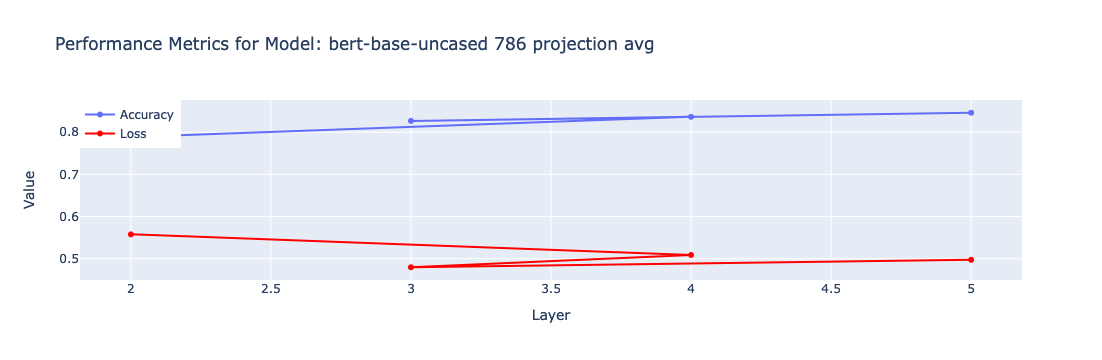

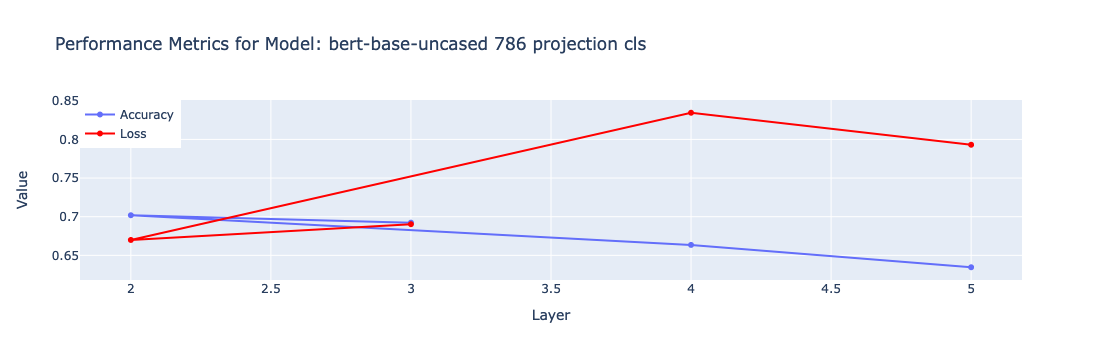

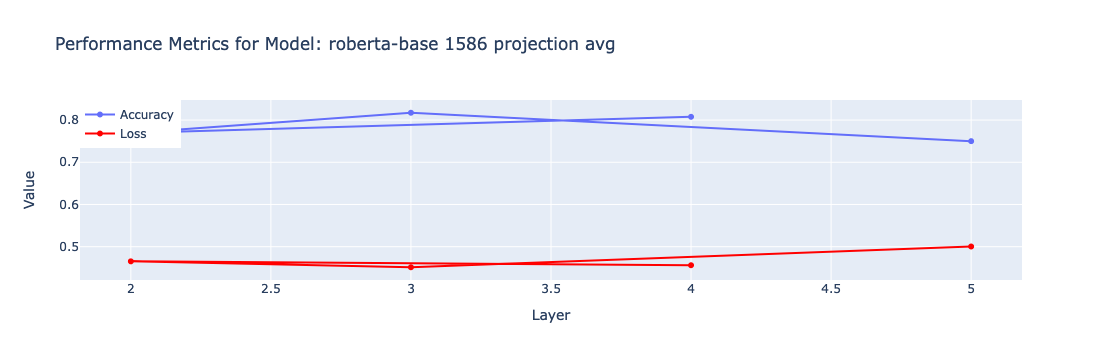

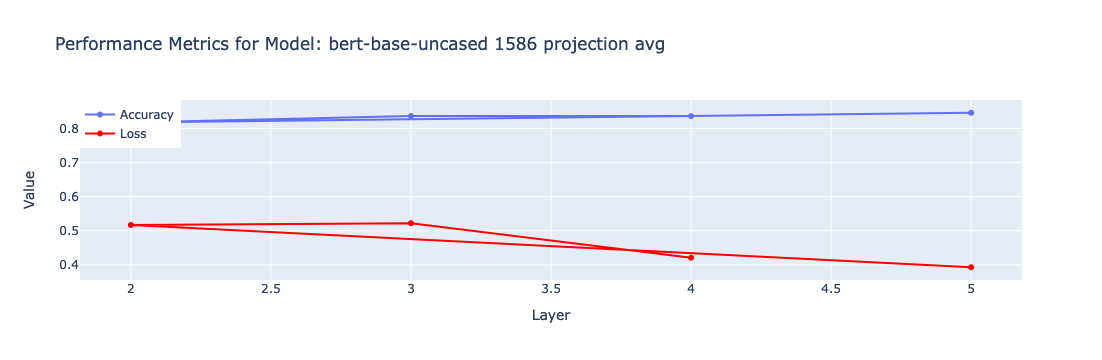

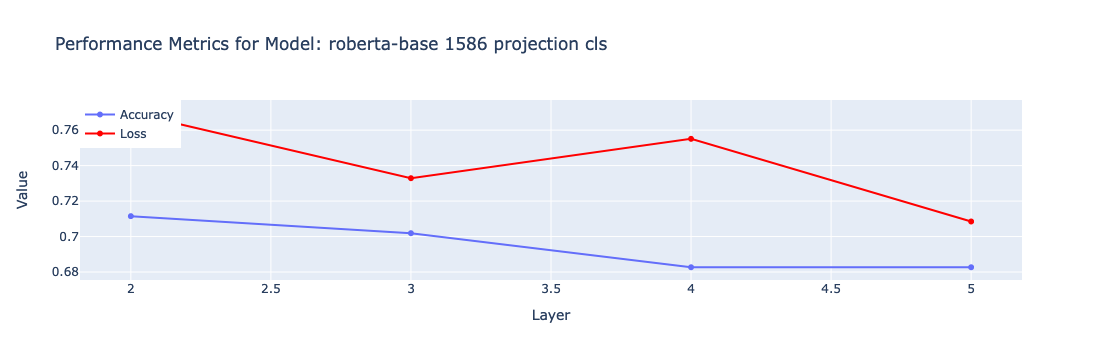

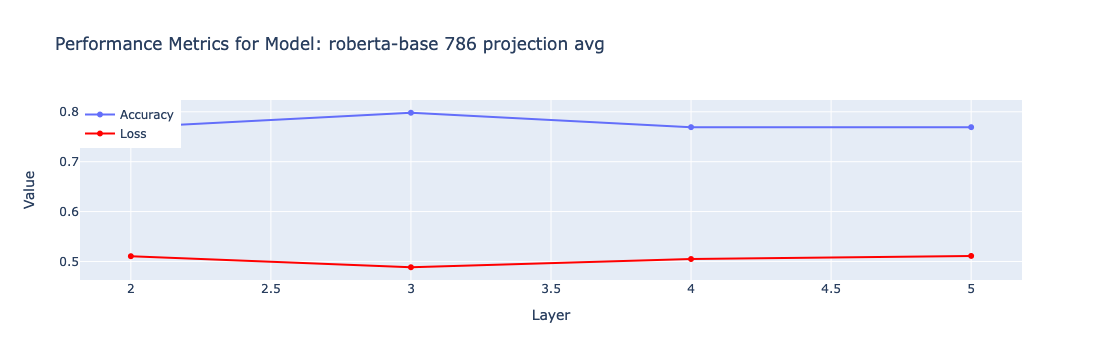

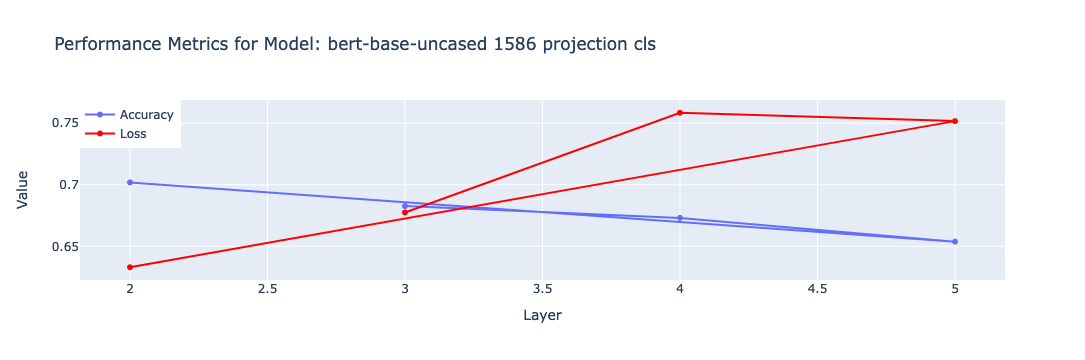

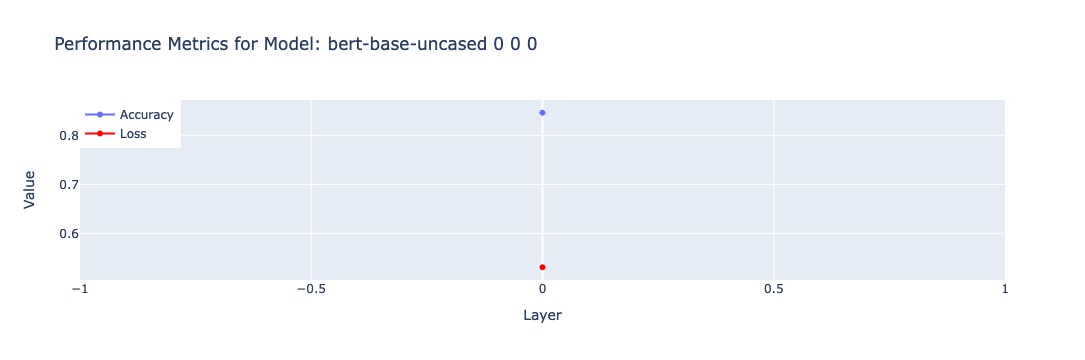

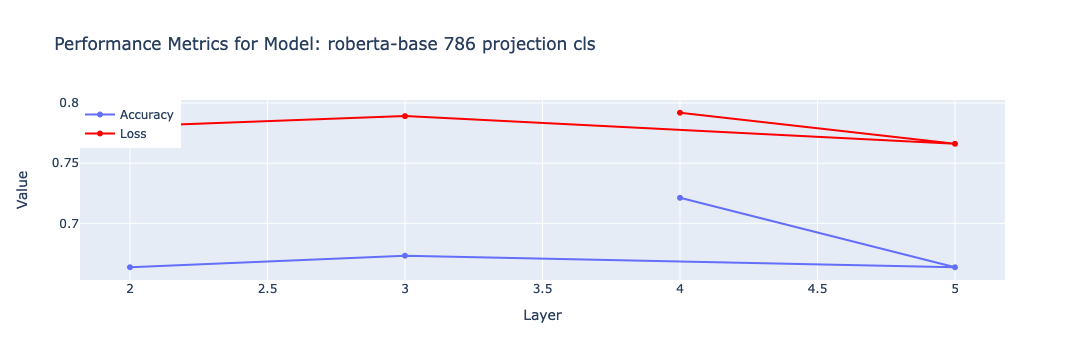

In [3]:
unique_settings = set((data['info']['model_name'], data['info']['polar_dimension'], 
                       data['info']['polarity_method'], data['info']['dataset_method']) for data in test_data.values())

for model_name, polar_dimension, polarity_method, dataset_method in unique_settings:
    plot_metrics_for_model_layers(test_data, model_name, polar_dimension, polarity_method, dataset_method)